In [1]:
import itertools
import json
import operator
import os
from pathlib import Path
from pprint import pprint
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline

## Load data and preprocess

### Metadata

In [2]:
# Map from test suite tag to high-level circuit.
circuits = {
    "Licensing": ["npi", "reflexive"],
    "Long-Distance Dependencies": ["fgd", "position", "embed", "number", "comparison"],
    "Garden-Path Effects": ["gardenpath", "npz", "mvrr"],
    "Gross Syntactic State": ["subordination"],
    "Center Embedding": ["center"],
    "Transformations": ["passive", "cleft"],
}

tag_to_circuit = {tag: circuit
                  for circuit, tags in circuits.items()
                  for tag in tags}

In [3]:
# Exclusions
exclude_suite_re = re.compile(r"^cleft_modifier|^fgd-embed[34]|^npz_(ambig)")

### Load

In [4]:
os.chdir("..")
ppl_data_path = Path("data/raw/perplexity.csv")
test_suite_results_path = Path("data/raw/test_suite_results")

In [5]:
perplexity_df = pd.read_csv(ppl_data_path, index_col=["model", "corpus", "seed"])
perplexity_df.index.set_names("model_name", level=0, inplace=True)

results_df = pd.concat([pd.read_csv(f) for f in test_suite_results_path.glob("*.csv")])

# Split model_id into constituent parts
model_ids = results_df.model.str.split("_", expand=True).rename(columns={0: "model_name", 1: "corpus", 2: "seed"})
results_df = pd.concat([results_df, model_ids], axis=1).drop(columns=["model"])
results_df["seed"] = results_df.seed.astype(int)

# Manual fixes
results_df.loc[results_df.model_name.isin(("bllip-lg", "bllip-md", "bllip-sm", "bllip-xs")), "model_name"] = "vanilla"

# Exclude test suites
exclude_filter = results_df.suite.str.contains(exclude_suite_re)
print("Dropping %i results / %i suites due to exclusions."
      % (exclude_filter.sum(), len(results_df[exclude_filter].suite.unique())))
results_df = results_df[~exclude_filter]

# Add tags
results_df["tag"] = results_df.suite.transform(lambda s: re.split(r"[-_0-9]", s)[0])
results_df["circuit"] = results_df.tag.map(tag_to_circuit)
tags_missing_circuit = set(results_df.tag.unique()) - set(tag_to_circuit.keys())
if tags_missing_circuit:
    print("Tags missing circuit: ", ", ".join(tags_missing_circuit))

Dropping 1354 results / 5 suites due to exclusions.
Tags missing circuit:  nn


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


In [6]:
results_df.head()

,suite,item,correct,model_name,corpus,seed,tag,circuit
0,reflexive_orc_fem,0,False,ordered-neurons,bllip-lg,111,reflexive,Licensing
1,reflexive_orc_fem,1,False,ordered-neurons,bllip-lg,111,reflexive,Licensing
2,reflexive_orc_fem,2,False,ordered-neurons,bllip-lg,111,reflexive,Licensing
3,reflexive_orc_fem,3,False,ordered-neurons,bllip-lg,111,reflexive,Licensing
4,reflexive_orc_fem,4,False,ordered-neurons,bllip-lg,111,reflexive,Licensing


### Checks

In [7]:
# Each model--corpus--seed should have perplexity data.
ids_from_results = results_df.set_index(["model_name", "corpus", "seed"]).sort_index().index
ids_from_ppl = perplexity_df.sort_index().index
diff = set(ids_from_results) - set(ids_from_ppl)
if diff:
    print("Missing perplexity results for:")
    pprint(diff)
    #raise ValueError("Each model--corpus--seed must have perplexity data.")

## Main analyses

1. barplot ranking model accuracies
2. scatter plot with ppl on x-axis and SG score on y-axis (for a given dataset size -- or maybe all of them together?)
3. variance in ppl vs variance in SG score for a single model across seeds and/or sizes

Test suite analyses

1. within-tag/circuit ppl-SG correlations
2. circuit-circuit coordination heatmap
3. robustness to stability modification}

### Global settings

e.g. to maintain consistent hues across model graphs, etc.

In [8]:
model_order = sorted(set(results_df.model_name))
corpus_order = ["bllip-lg", "bllip-md", "bllip-sm", "bllip-xs"]
circuit_order = sorted([c for c in results_df.circuit.dropna().unique()])

### Data prep

In [9]:
suites_df = results_df.groupby(["model_name", "corpus", "seed", "suite"]).correct.mean().reset_index()
suites_df["tag"] = suites_df.suite.transform(lambda s: re.split(r"[-_0-9]", s)[0])
suites_df["circuit"] = suites_df.tag.map(tag_to_circuit)

In [10]:
# Join PPL and accuracy data.
joined_data = suites_df.groupby(["model_name", "corpus", "seed"]).correct.agg("mean")
joined_data = pd.DataFrame(joined_data).join(perplexity_df).reset_index()
joined_data.head()

,model_name,corpus,seed,correct,pid,test_loss,test_ppl
0,ordered-neurons,bllip-lg,111,0.319486,NaN,4.03,56.38
1,ordered-neurons,bllip-md,111,0.381992,NaN,4.02,55.96
2,ordered-neurons,bllip-sm,111,0.395236,NaN,3.99,53.85
3,ordered-neurons,bllip-sm,120,0.433366,NaN,3.99,54.06
4,ordered-neurons,bllip-xs,111,0.356769,NaN,4.30,73.46


In [11]:
# Join PPL and accuracy data, splitting on circuit.
joined_data_circuits = suites_df.groupby(["model_name", "corpus", "seed", "circuit"]).correct.agg("mean")
joined_data_circuits = pd.DataFrame(joined_data_circuits).reset_index().set_index(["model_name", "corpus", "seed"]).join(perplexity_df).reset_index()
joined_data_circuits.head()

,model_name,corpus,seed,circuit,correct,pid,test_loss,test_ppl
0,ordered-neurons,bllip-lg,111,Center Embedding,0.571429,NaN,4.03,56.38
1,ordered-neurons,bllip-lg,111,Garden-Path Effects,0.437500,NaN,4.03,56.38
2,ordered-neurons,bllip-lg,111,Licensing,0.000000,NaN,4.03,56.38
3,ordered-neurons,bllip-lg,111,Long-Distance Dependencies,0.584900,NaN,4.03,56.38
4,ordered-neurons,bllip-lg,111,Transformations,1.000000,NaN,4.03,56.38


In [12]:
# Analyze stability to modification.
def has_modifier(ts):
    if ts.endswith(("_modifier", "_mod")):
        return True
    else:
        return None
results_df["has_modifier"] = results_df.suite.transform(has_modifier)

# Mark "non-modifier" test suites
modifier_ts = results_df[results_df.has_modifier == True].suite.unique()
no_modifier_ts = [re.sub(r"_mod(ifier)?$", "", ts) for ts in modifier_ts]
results_df.loc[results_df.suite.isin(no_modifier_ts), "has_modifier"] = False
# Store subset of test suites which have definite modifier/no-modifier marking
results_df_mod = results_df[~(results_df.has_modifier.isna())]
# Get base test suite (without modifier/no-modifier marking)
results_df_mod["test_suite_base"] = results_df_mod.suite.transform(lambda ts: ts.strip("_no-modifier").strip("_modifier"))
results_df_mod.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,suite,item,correct,model_name,corpus,seed,tag,circuit,has_modifier,test_suite_base
133,gardenpath_mod,0,False,ordered-neurons,bllip-lg,111,gardenpath,Garden-Path Effects,True,gardenpath
134,gardenpath_mod,1,False,ordered-neurons,bllip-lg,111,gardenpath,Garden-Path Effects,True,gardenpath
135,gardenpath_mod,2,False,ordered-neurons,bllip-lg,111,gardenpath,Garden-Path Effects,True,gardenpath
136,gardenpath_mod,3,False,ordered-neurons,bllip-lg,111,gardenpath,Garden-Path Effects,True,gardenpath
137,gardenpath_mod,4,False,ordered-neurons,bllip-lg,111,gardenpath,Garden-Path Effects,True,gardenpath


### Accuracy across models

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Accuracy')

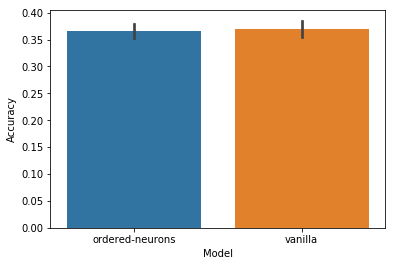

In [13]:
sns.barplot(data=results_df.reset_index(), x="model_name", y="correct")

plt.xlabel("Model")
plt.ylabel("Accuracy")

### Accuracy vs perplexity

In [14]:
corpus_to_size = {
    "bllip-xs": 2,
    "bllip-sm": 8,
    "bllip-md": 14,
    "bllip-lg": 20,
}

model_colors = dict(zip(model_order,
                        ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']))

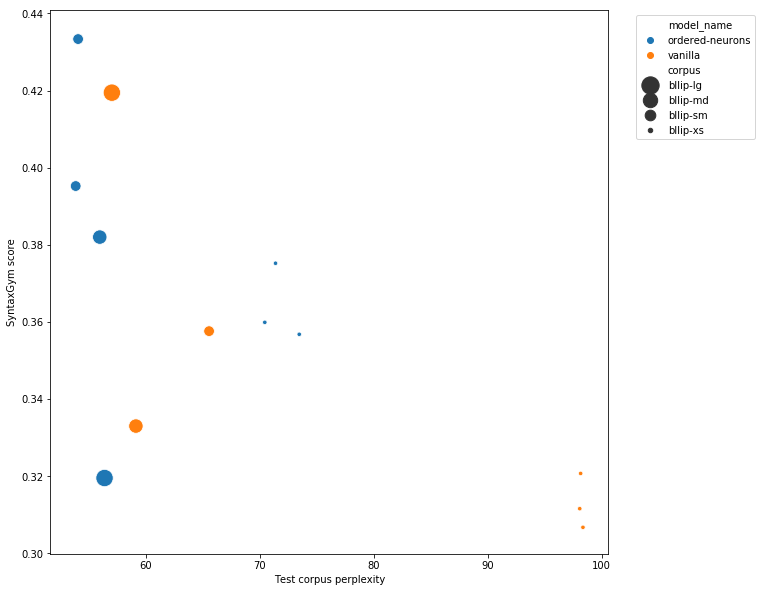

In [15]:
f, ax = plt.subplots(figsize=(10, 10))
# sns.regplot(data=graph_data, x="test_ppl", y="correct",
#             scatter_kws={"s": graph_data["corpus"].map(corpus_to_size),
#                          "facecolors": graph_data.model.map(model_colors)})
sns.scatterplot(data=joined_data, x="test_ppl", y="correct",
                hue="model_name", size="corpus", sizes=(20, 300),
                hue_order=model_order, size_order=corpus_order)
plt.xlabel("Test corpus perplexity")
plt.ylabel("SyntaxGym score")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

(0, 1)

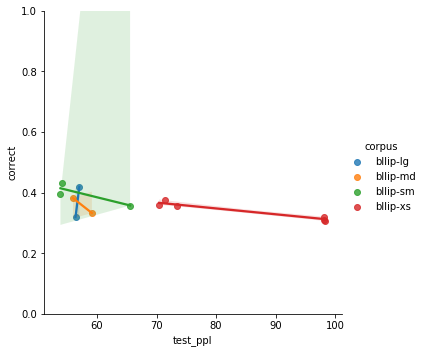

In [16]:
g = sns.lmplot(data=joined_data, x="test_ppl", y="correct",
               hue="corpus", truncate=True)
g.ax.set_ylim((0, 1))

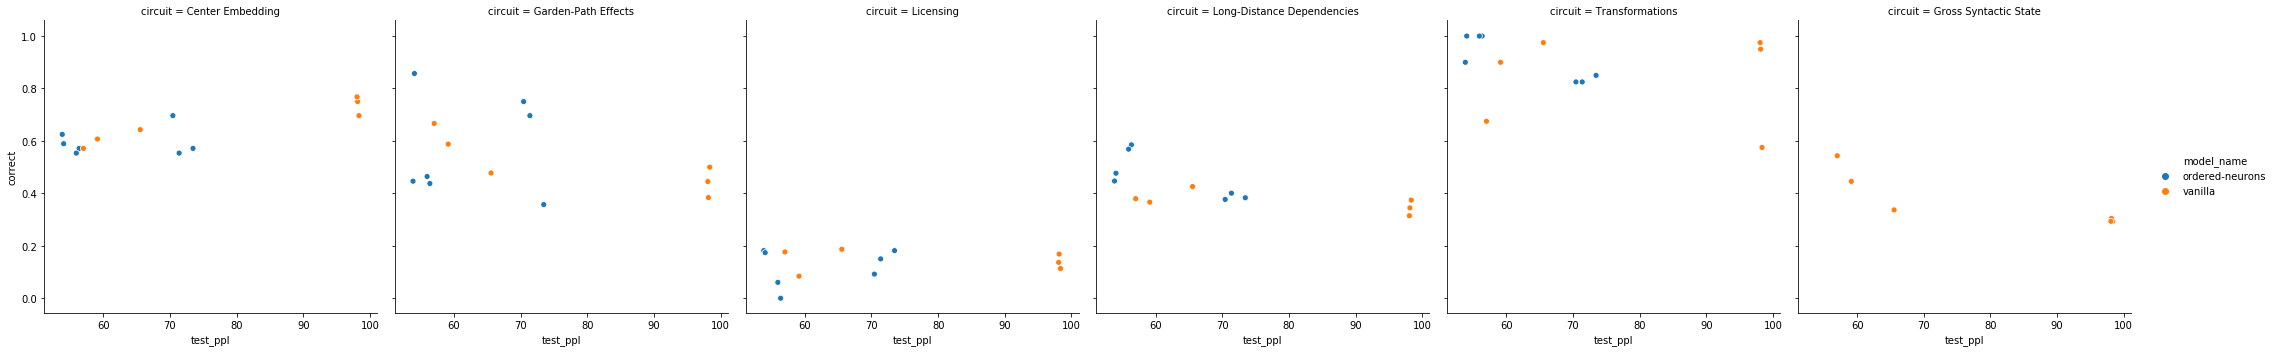

In [17]:
g = sns.FacetGrid(data=joined_data_circuits, col="circuit", height=5)
g.map(sns.scatterplot, "test_ppl", "correct", "model_name",
      hue_order=model_order)
g.add_legend()

In [18]:
joined_data_circuits.groupby(["model_name", "corpus", "circuit"]).correct.mean()

model_name       corpus    circuit                   
ordered-neurons  bllip-lg  Center Embedding              0.571429
                           Garden-Path Effects           0.437500
                           Licensing                     0.000000
                           Long-Distance Dependencies    0.584900
                           Transformations               1.000000
                 bllip-md  Center Embedding              0.553571
                           Garden-Path Effects           0.464286
                           Licensing                     0.060526
                           Long-Distance Dependencies    0.568609
                           Transformations               1.000000
                 bllip-sm  Center Embedding              0.607143
                           Garden-Path Effects           0.651786
                           Licensing                     0.177632
                           Long-Distance Dependencies    0.461936
                      

### Item-level prediction correlations across models

In [19]:
item_predictions = results_df.set_index(["suite", "item"]).sort_index().groupby(["model_name", "corpus", "seed"]).correct.apply(np.array)
# model_correlations = []
# for k1, k2 in itertools.combinations(list(item_predictions.index), 2):
#     #model_correlations.append((k1, k2, stats.spearmanr(item_predictions.loc[k1], item_predictions.loc[k2])))
# model_correlations

### Variance in accuracy vs variance in perplexity

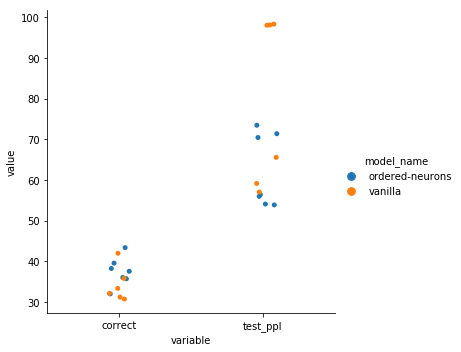

In [20]:
catplot_ticks = ["correct", "test_ppl"]
catplot_data = joined_data.copy()
catplot_data["correct"] *= 100
catplot_data = catplot_data.melt(id_vars=set(catplot_data.columns) - set(catplot_ticks))
catplot_data["corpus_size"] = catplot_data.corpus.map(corpus_to_size)

g = sns.catplot(data=catplot_data,
                x="variable", y="value", hue="model_name")

### Circuit–circuit correlations

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,0.98,'Circuit--circuit correlations')

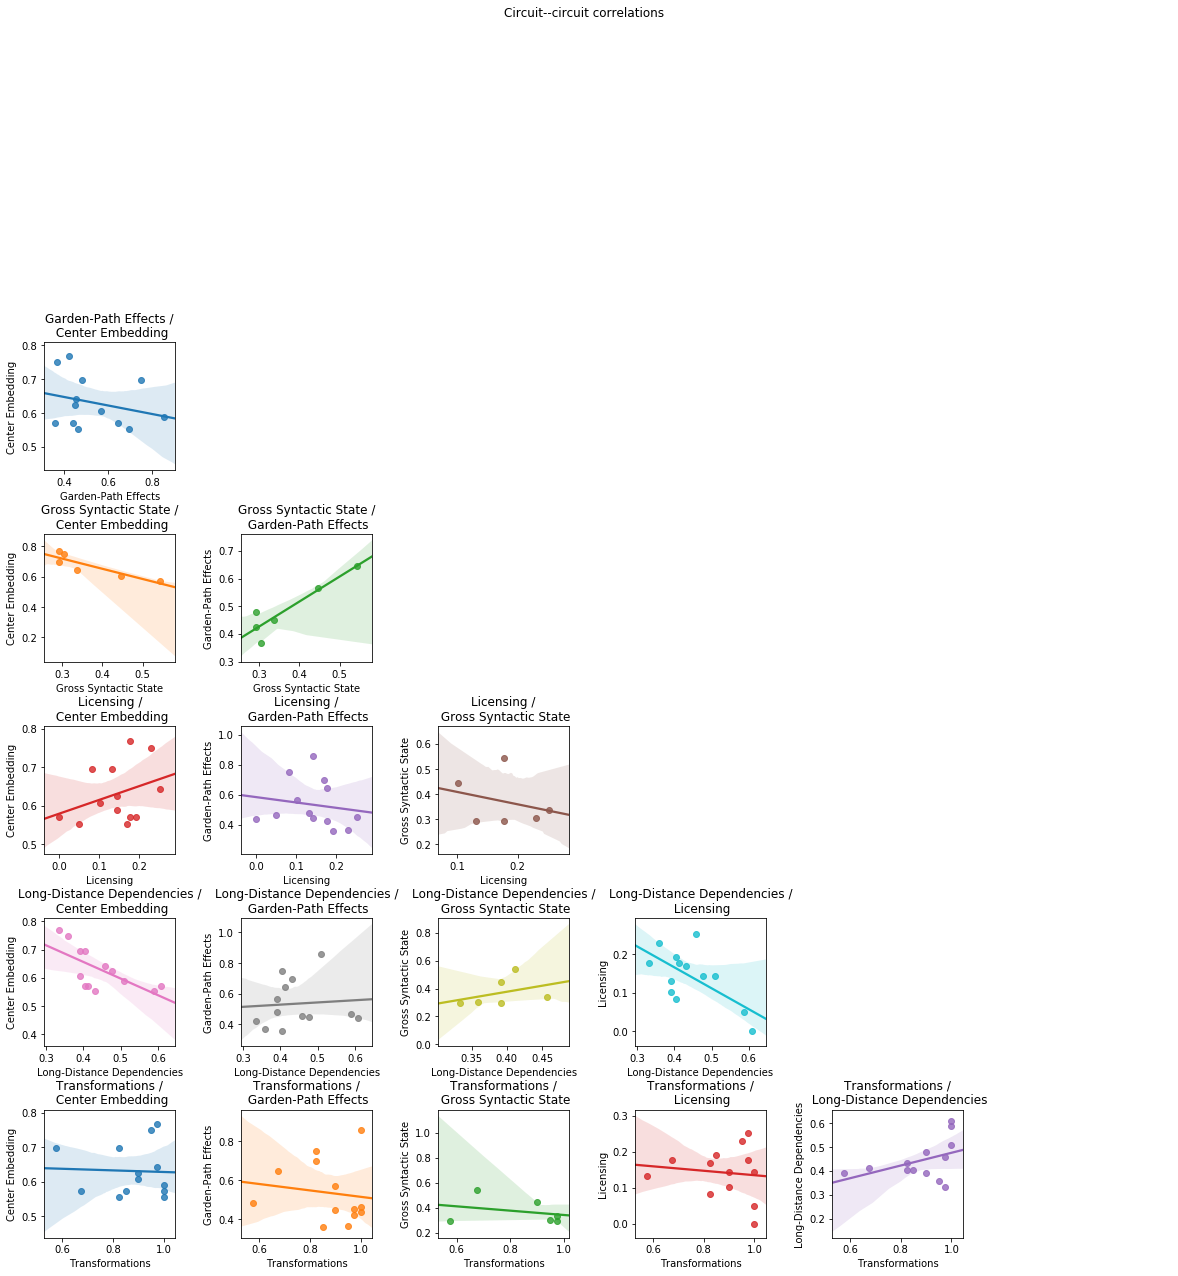

In [21]:
f, axs = plt.subplots(len(circuit_order), len(circuit_order), figsize=(20, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for c1, row in zip(circuit_order, axs):
    for c2, ax in zip(circuit_order, row):
        if c1 <= c2:
            ax.axis("off")
            continue
            
        xs = results_df[results_df.circuit == c1].groupby(["model_name", "corpus", "seed"]).correct.agg({c1: "mean"})
        ys = results_df[results_df.circuit == c2].groupby(["model_name", "corpus", "seed"]).correct.agg({c2: "mean"})
        df = pd.concat([xs, ys], axis=1)
        ax.set_title("%s /\n %s" % (c1, c2))
        sns.regplot(data=df, x=c1, y=c2, ax=ax)
        
plt.suptitle("Circuit--circuit correlations")

### Stability to modification

Text(0.5,1,'Stability to modification')

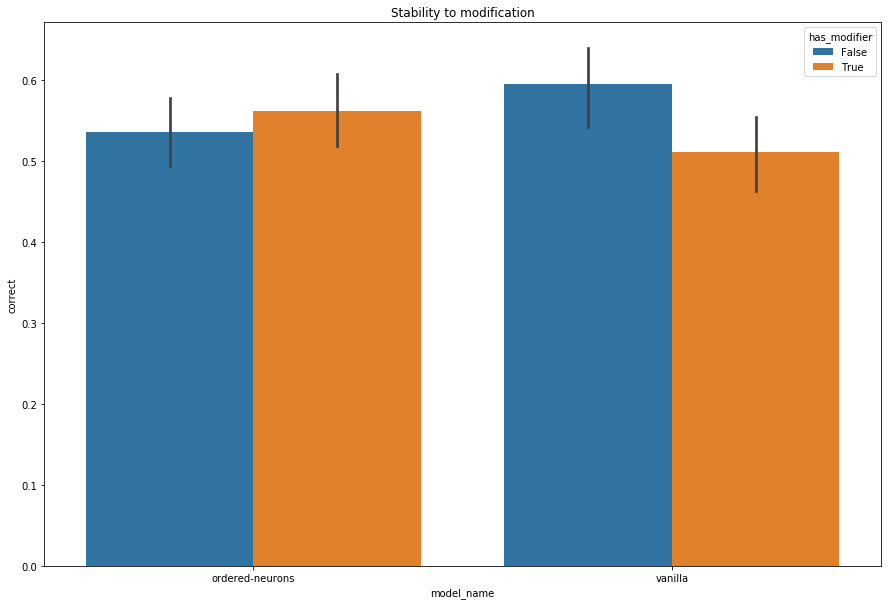

In [22]:
plt.subplots(figsize=(15, 10))
sns.barplot(data=results_df_mod, x="model_name", y="correct", hue="has_modifier")
plt.title("Stability to modification")

Text(0.5,1,'Stability to modification')

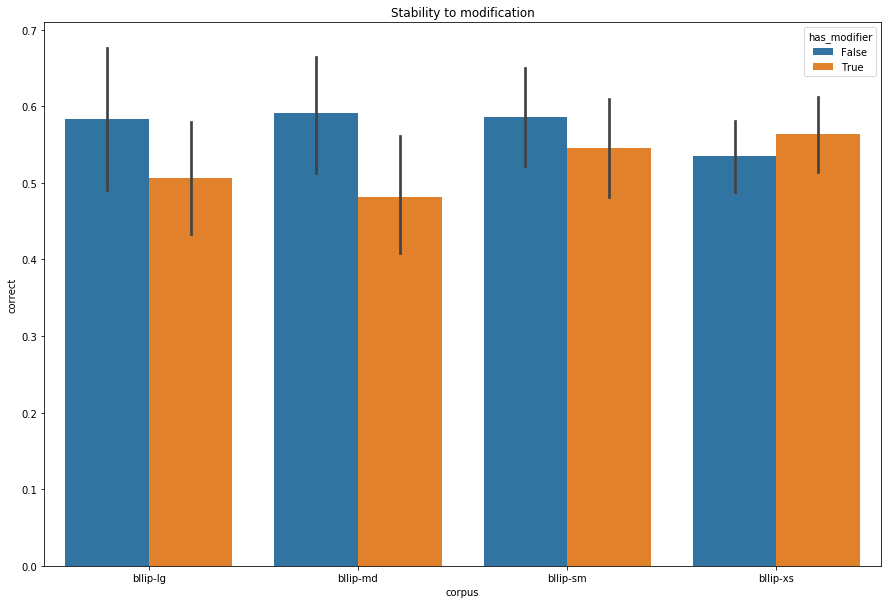

In [23]:
plt.subplots(figsize=(15, 10))
sns.barplot(data=results_df_mod, x="corpus", y="correct", hue="has_modifier")
plt.title("Stability to modification")

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


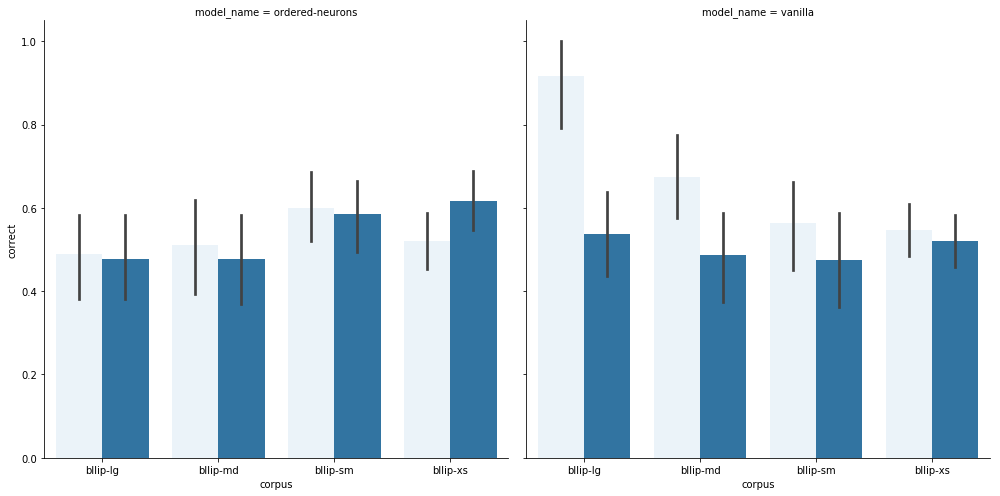

In [24]:
g = sns.FacetGrid(data=results_df_mod, col="model_name", height=7)
g.map(sns.barplot, "corpus", "correct", "has_modifier")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Change in accuracy due to modification')

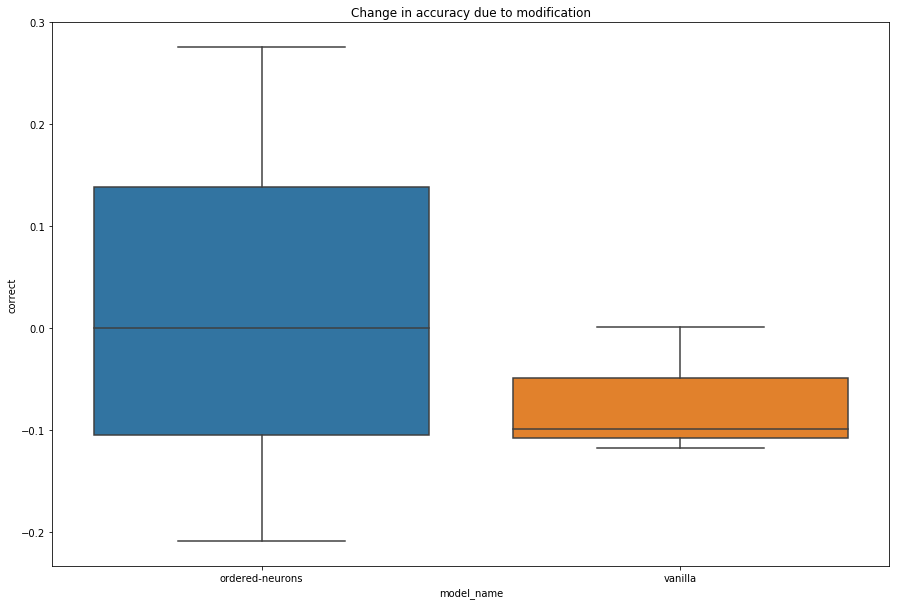

In [25]:
avg_mod_results = results_df_mod.groupby(["model_name", "test_suite_base", "has_modifier"]).correct.agg({"correct": "mean"}).sort_index()
avg_mod_diffs = avg_mod_results.xs(True, level="has_modifier") - avg_mod_results.xs(False, level="has_modifier")

plt.subplots(figsize=(15, 10))
sns.boxplot(data=avg_mod_diffs.reset_index(), x="model_name", y="correct")
plt.title("Change in accuracy due to modification")